#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [17]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# turning off scientific notation
#pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [18]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")

In [20]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [21]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [22]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [23]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [24]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [25]:
data = data.loc[~(data.transmission == "manual")]

In [26]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [27]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [28]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [29]:
# only LE types cars and age at least 5 yo
data=data[data['LE'] == 1]
data = data[data['age'] >= 5]
data

,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,size,...,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,agesq,agecu,odometersq
6,chicago,chicago city,1998 toyota camry le,Missing,Missing,Missing,gas,16.824259,NaN,NaN,...,1,0,0,0,0,0,0,400,8000,283.055684
9,chicago,chicago city,2000 toyota camry le,excellent,4 cylinders,fwd,gas,10.700000,white,mid-size,...,1,0,0,1,0,0,0,324,5832,114.490000
15,chicago,chicago city,2005 toyota camry LE,excellent,6 cylinders,4wd,gas,12.045100,grey,full-size,...,1,0,0,1,0,0,1,169,2197,145.084434
25,chicago,chicago city,2010 toyota camry le,Missing,Missing,Missing,gas,14.664000,NaN,NaN,...,1,0,0,0,0,0,0,64,512,215.032883
32,chicago,chicago city,2002 toyota camry le,like new,6 cylinders,Missing,gas,12.100000,grey,NaN,...,1,0,0,0,0,1,1,256,4096,146.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,los angeles,LA san gabriel,2010 toyota camry le,like new,4 cylinders,Missing,gas,12.000000,white,NaN,...,1,0,0,0,0,1,0,64,512,144.000000
526,los angeles,San Fernando,2012 toyota camry le,Missing,Missing,Missing,gas,8.304974,NaN,NaN,...,1,0,0,0,0,0,0,36,216,68.972587
527,los angeles,LA long beach,2005 toyota camry le,Missing,4 cylinders,Missing,gas,19.000000,NaN,NaN,...,1,0,0,0,0,0,0,169,2197,361.000000
530,los angeles,LA san gabriel,2001 Toyota Camry le,Missing,Missing,Missing,gas,22.800000,NaN,NaN,...,1,0,0,0,0,0,0,289,4913,519.840000


In [30]:
# Frequency tables
# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
area,,
chicago,52,4031.057692
los angeles,34,5462.588235


In [13]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]

In [31]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
condition,,
Missing,22,3993.681818
excellent,26,4877.461538
good,26,3649.769231
like new,12,7147.833333


In [32]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
drive,,
4wd,1,4200.000000
Missing,35,4396.000000
fwd,48,4682.979167
rwd,2,6250.000000


In [33]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
dealer,,
0,76,4578.763158
1,10,4735.700000


In [34]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,86.000000,86.000000,86.0,86.0,86.000000,86.000000,86.000000,86.000000,86.00000
mean,13.662791,13.750198,1.0,0.0,0.104651,0.139535,0.302326,0.302326,0.05814
std,4.447367,3.926067,0.0,0.0,0.307899,0.348536,0.461959,0.461959,0.23538
min,5.000000,3.200000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
25%,10.000000,12.011275,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
50%,14.000000,14.326721,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
75%,17.000000,16.450363,1.0,0.0,0.000000,0.000000,1.000000,1.000000,0.00000
max,24.000000,22.800000,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.00000


## Linear regressions

In [35]:
# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [37]:
# Matrix form

X1 = data[['age', 'agesq']]  
Y = data['price']          

model1 = LinearRegression()
model1.fit(X1, Y)
print(model1.coef_, model1.intercept_)

[-826.99547153   12.54145499] 13309.767148279965


In [38]:
# Matrix form

X2 = data[['age', 'agesq', 'odometer', 'odometersq', 'LE', 'cond_excellent', 'cond_good', 'dealer']]  
Y = data['price']          

model2 = LinearRegression()
model2.fit(X2, Y)
print(model2.coef_, model2.intercept_)

[-4.73889982e+02  2.99045981e+00 -8.01876315e+02  2.17290895e+01
  2.17426077e-12  5.87427534e+02  5.01135520e+02  5.37687375e+02] 16649.999669111763


Estimate ALL regressions

In [39]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

### Table 13.2 Regression models for predicting used car price

In [40]:
stargazer.Stargazer(regs[:5])

In [41]:
# not using startgazer

import statsmodels.formula.api as smf

results = [smf.ols(eq, data=data).fit() for eq in model_equations]

for i, res in enumerate(results, 1):
    print(f"\nModel {i} Summary:")
    print(res.summary())


Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     102.4
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           3.88e-23
Time:                        03:46:18   Log-Likelihood:                -743.88
No. Observations:                  86   AIC:                             1494.
Df Residuals:                      83   BIC:                             1501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.331e+04   1363.821  

## Cross validation

Use custom function `ols_crossvalidator` for cross validation

I run sklearn library

Set n_fold = 4 for 4-fold cross-validation

Cross-validate models

In [84]:
# for model2: model2 = "price ~ age + agesq + odometer"
# Define predictors and target
X = data[["age", "agesq", "odometer"]]  
y = data["price"]                       

# 2. Set up KFold  with 5. folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []

# 3. Loop through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# 4. Average RMSE
average_rmse = np.mean(rmse_list)

print("RMSEs for each fold:", rmse_list)
print("Average RMSE:", average_rmse)

RMSEs for each fold: [1649.78461830922, 1638.748453505182, 1325.5233013689963, 1276.5842377501262, 1441.4061811610047]
Average RMSE: 1466.4093584189056


In [42]:
k_fold = 8

In [43]:
model1 = "price ~ age + agesq"
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

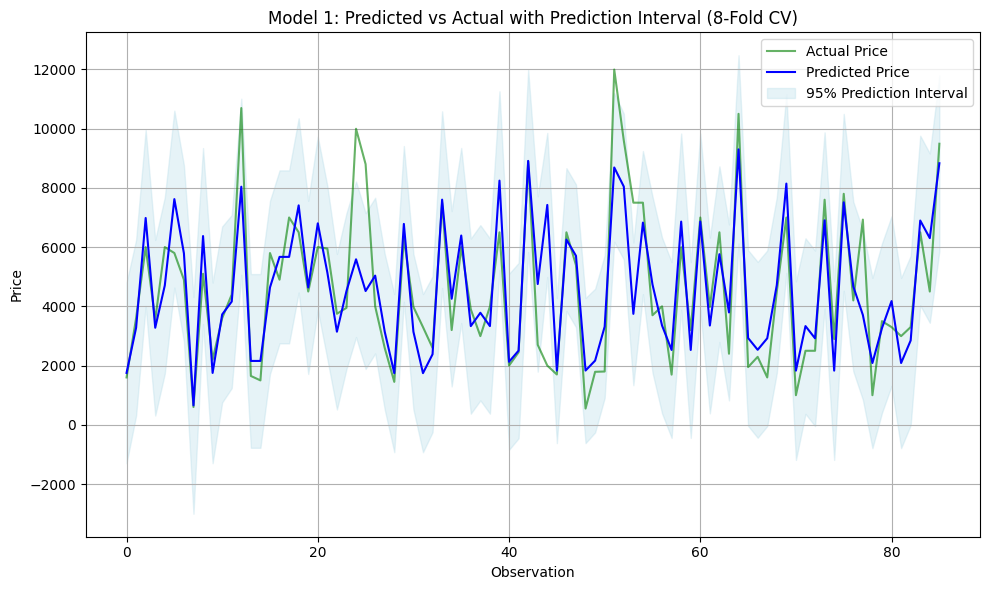

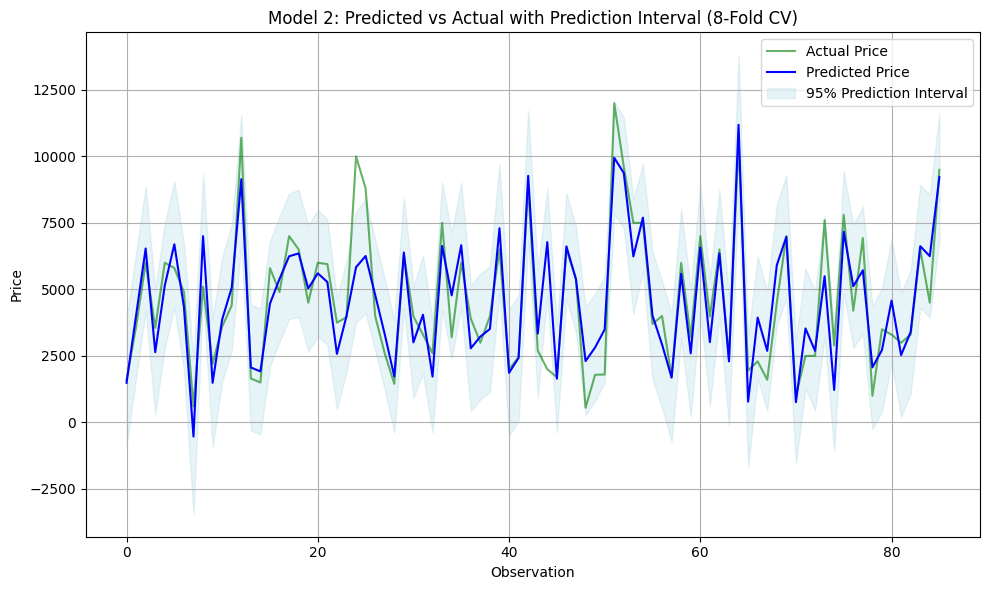

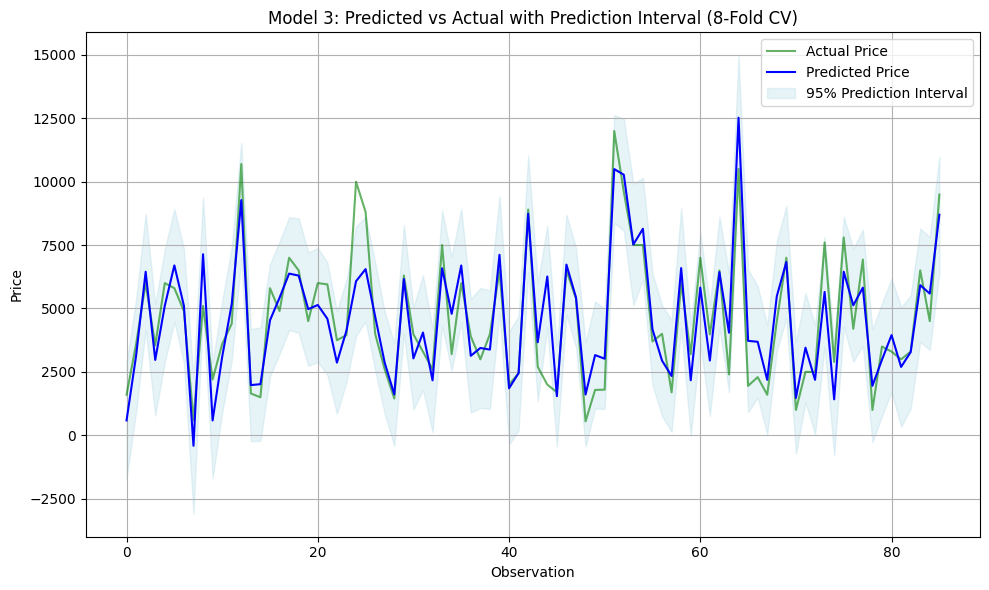

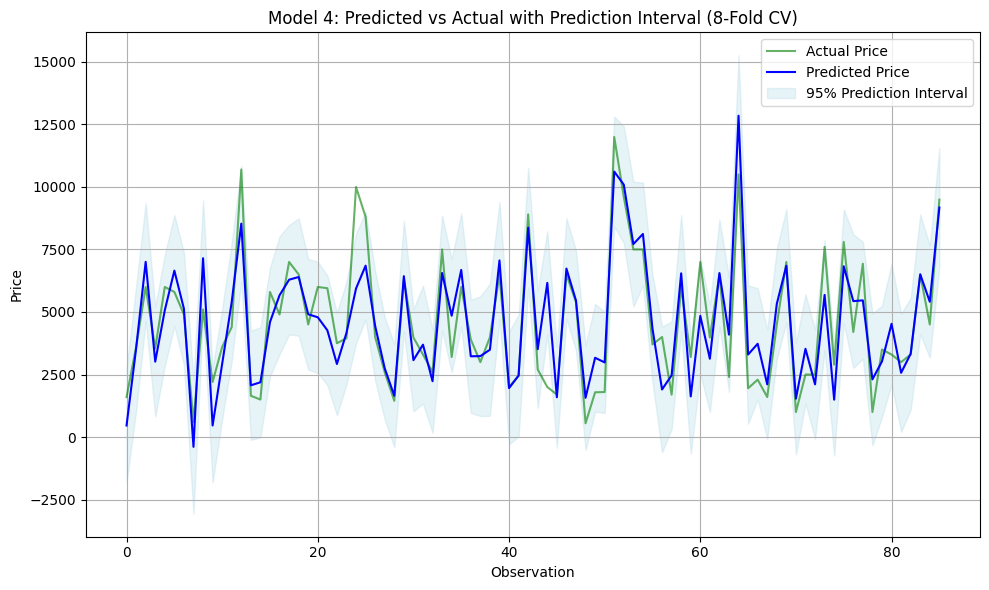

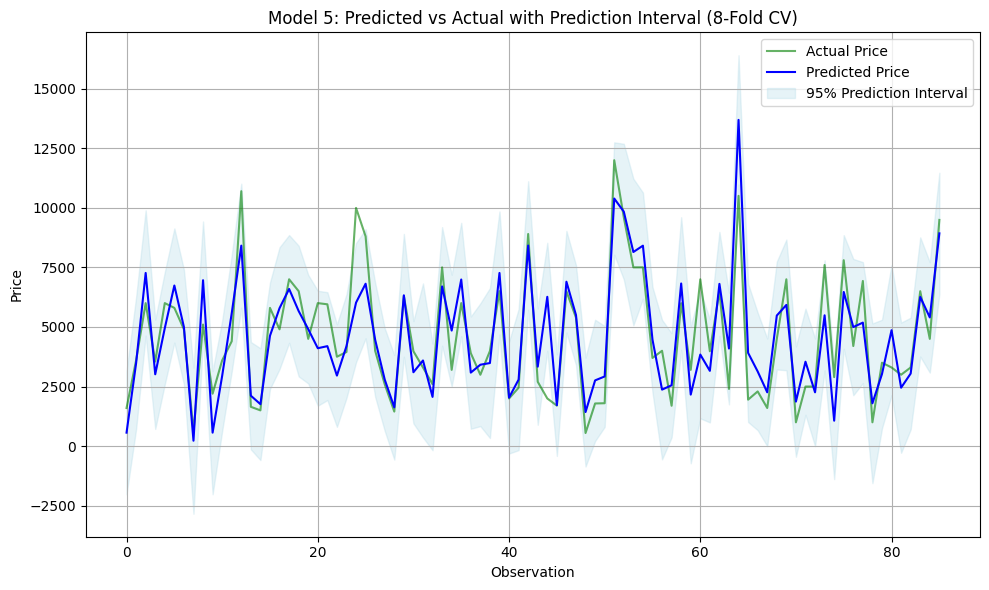

In [44]:
model_equations = [
    "price ~ age + agesq",
    "price ~ age + agesq + odometer",
    "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"
]
# Prepare KFold
kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
results_tables = []


# Loop through models
for i, formula in enumerate(model_equations):
    preds = []
    lowers = []
    uppers = []
    actuals = []
    diff = []

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        
        model = smf.ols(formula, data=train_data).fit()
        pred_result = model.get_prediction(test_data)
        summary_frame = pred_result.summary_frame(alpha=0.05)  # 95% interval
        
        preds.extend(summary_frame['mean'])
        lowers.extend(summary_frame['obs_ci_lower'])
        uppers.extend(summary_frame['obs_ci_upper'])
        actuals.extend(test_data['price'])
        diff.extend(test_data['price'] - summary_frame['mean'])

    # Plot for this model
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Price', color = 'green', alpha=0.6)
    plt.plot(preds, label='Predicted Price', color='blue')
    plt.fill_between(range(len(preds)), lowers, uppers, color='lightblue', alpha=0.3, label='95% Prediction Interval')
    plt.title(f'Model {i+1}: Predicted vs Actual with Prediction Interval ({k_fold}-Fold CV)')
    plt.xlabel("Observation")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]    
        plt.show()

### Test Set with Predicitions ,Actuals, Diffs and CI Intervals

In [45]:
tables = []
for i, formula in enumerate(model_equations):
    # Fit the model on the whole data (or use your CV split as needed)
    model = smf.ols(formula, data=data).fit()
    pred_result = model.get_prediction(data)
    summary_frame = pred_result.summary_frame(alpha=0.05)
    
    table = pd.DataFrame({
        "Model Name": [f"Model {i+1}"] * len(data),
        "Actual": data["price"].values,
        "Predicted": summary_frame["mean"].values,
        "Diffs": data["price"].values - summary_frame["mean"].values,
        "Lower Bound": summary_frame["obs_ci_lower"].values,
        "Upper Bound": summary_frame["obs_ci_upper"].values,
    })
    table.reset_index(drop=True, inplace=True)
    tables.append(table)

# Display all tables
for table in tables:
    display(table)

,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 1,1600,1786.439715,-186.439715,-1080.224317,4653.103746
1,Model 1,2295,2487.280078,-192.280078,-341.038261,5315.598418
2,Model 1,4200,4678.331912,-478.331912,1849.384382,7507.279442
3,Model 1,2000,7496.456496,-5496.456496,4652.162004,10340.750987
4,Model 1,3600,3288.452082,311.547918,463.449376,6113.454788
...,...,...,...,...,...,...
81,Model 1,7800,7496.456496,303.543504,4652.162004,10340.750987
82,Model 1,8900,8799.286699,100.713301,5881.245271,11717.328127
83,Model 1,2700,4678.331912,-1978.331912,1849.384382,7507.279442
84,Model 1,1950,2875.324625,-925.324625,50.933430,5699.715820


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 2,1600,1676.512776,-76.512776,-607.213491,3960.239043
1,Model 2,2295,3748.003383,-1453.003383,1466.641179,6029.365587
2,Model 2,4200,5080.913134,-880.913134,2824.534032,7337.292236
3,Model 2,2000,6594.786915,-4594.786915,4314.606264,8874.967566
4,Model 2,3600,4003.721742,-403.721742,1744.206467,6263.237018
...,...,...,...,...,...,...
81,Model 2,7800,7266.104931,533.895069,4999.463618,9532.746244
82,Model 2,8900,9207.316499,-307.316499,6879.979363,11534.653635
83,Model 2,2700,3328.304108,-628.304108,1042.312190,5614.296026
84,Model 2,1950,993.065673,956.934327,-1319.675715,3305.807061


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 3,1600,1027.951588,572.048412,-1148.083235,3203.986410
1,Model 3,2295,3584.003387,-1289.003387,1409.204953,5758.801822
2,Model 3,4200,5076.117390,-876.117390,2941.839405,7210.395375
3,Model 3,2000,5964.024067,-3964.024067,3802.265996,8125.782137
4,Model 3,3600,3311.970245,288.029755,1166.579491,5457.360999
...,...,...,...,...,...,...
81,Model 3,7800,6556.742345,1243.257655,4406.310246,8707.174443
82,Model 3,8900,8753.466206,146.533794,6565.072522,10941.859890
83,Model 3,2700,3603.368923,-903.368923,1402.375689,5804.362157
84,Model 3,1950,2470.982745,-520.982745,28.971860,4912.993631


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 4,1600,922.577115,677.422885,-1262.695992,3107.850222
1,Model 4,2295,3616.906156,-1321.906156,1433.364355,5800.447958
2,Model 4,4200,4881.579883,-681.579883,2528.955432,7234.204333
3,Model 4,2000,5759.643599,-3759.643599,3577.405090,7941.882107
4,Model 4,3600,3636.343366,-36.343366,1289.873593,5982.813139
...,...,...,...,...,...,...
81,Model 4,7800,7017.279109,782.720891,4792.894563,9241.663655
82,Model 4,8900,8411.344657,488.655343,6171.975325,10650.713990
83,Model 4,2700,3459.844313,-759.844313,1247.962667,5671.725958
84,Model 4,1950,2303.088600,-353.088600,-154.358023,4760.535222


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 5,1600,1113.566968,486.433032,-1223.061049,3450.194985
1,Model 5,2295,3149.554461,-854.554461,783.998933,5515.109988
2,Model 5,4200,4807.243267,-607.243267,1937.258419,7677.228115
3,Model 5,2000,5480.750582,-3480.750582,3145.691381,7815.809783
4,Model 5,3600,3622.044331,-22.044331,1132.232103,6111.856559
...,...,...,...,...,...,...
81,Model 5,7800,6791.787672,1008.212328,4460.116797,9123.458548
82,Model 5,8900,8526.478220,373.521780,6089.280486,10963.675955
83,Model 5,2700,3302.486200,-602.486200,1015.622084,5589.350315
84,Model 5,1950,2378.204715,-428.204715,-171.782377,4928.191807


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = []
for i, formula in enumerate(model_equations):
    model = smf.ols(formula, data=data).fit()
    y_true = data["price"]
    y_pred = model.fittedvalues

    r2 = r2_score(y_true, y_pred)
    bic = model.bic
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics.append({
        "Model": f"Model {i+1}",
        "R2": r2,
        "BIC": bic,
        "RMSE": rmse,
        "MAE": mae
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Model,R2,BIC,RMSE,MAE
0,Model 1,0.711623,1501.116266,1381.312638,967.642505
1,Model 2,0.819286,1465.378434,1093.472894,794.762976
2,Model 3,0.850245,1467.034954,995.410793,768.733306
3,Model 4,0.855636,1477.244793,977.328606,749.034201
4,Model 5,0.862429,1504.280380,954.058515,752.154704


In [48]:
#R2 evaluation
metrics_df.nlargest(2, 'R2')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.862429,1504.280380,954.058515,752.154704
3,Model 4,0.855636,1477.244793,977.328606,749.034201


In [49]:
#BIC evaluation
metrics_df.nsmallest(2, 'BIC')

,Model,R2,BIC,RMSE,MAE
1,Model 2,0.819286,1465.378434,1093.472894,794.762976
2,Model 3,0.850245,1467.034954,995.410793,768.733306


In [50]:
#RMSE evaluation
metrics_df.nsmallest(2, 'RMSE')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.862429,1504.280380,954.058515,752.154704
3,Model 4,0.855636,1477.244793,977.328606,749.034201


In [51]:
#MAE evaluation (CV)
metrics_df.nsmallest(2, 'MAE')

,Model,R2,BIC,RMSE,MAE
3,Model 4,0.855636,1477.244793,977.328606,749.034201
4,Model 5,0.862429,1504.280380,954.058515,752.154704


In [90]:
# for all models and using k fold = 10

def ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False):
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()
        y_pred = model.predict(test_data)
        y_true = test_data[equation.split("~")[0].strip()]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)

    if average_rmse:
        return np.mean(rmse_list)
    else:
        return rmse_list

cv_list = []
for equation in model_equations:
    result = ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False)
    cv_list.append(result)
cv_list


[[np.float64(1757.33930701584),
  np.float64(2174.286815061449),
  np.float64(1630.1841204625018),
  np.float64(1625.6557182051922),
  np.float64(1749.7117567835446),
  np.float64(1640.8318034708147),
  np.float64(1249.5092850328094),
  np.float64(2177.439653236588)],
 [np.float64(1602.572796374926),
  np.float64(1862.6534746192776),
  np.float64(1522.2447513917848),
  np.float64(1084.5262832187655),
  np.float64(1357.621384052129),
  np.float64(1237.1165685859924),
  np.float64(1292.0746955915215),
  np.float64(1572.1906233779973)],
 [np.float64(1394.1722466631702),
  np.float64(1778.1437898601293),
  np.float64(1420.3170056848753),
  np.float64(1020.3699493403248),
  np.float64(1299.0203041433804),
  np.float64(1167.083881850147),
  np.float64(1270.483587808249),
  np.float64(1396.25448115234)],
 [np.float64(1390.817175818098),
  np.float64(1612.7204692218104),
  np.float64(1351.7089356448744),
  np.float64(1163.652370907822),
  np.float64(1374.869455061391),
  np.float64(1208.681227

### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [91]:
pd.DataFrame(
    cv_list,
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,1757,1603,1394,1391,1402
Fold2,2174,1863,1778,1613,1592
Fold3,1630,1522,1420,1352,1432
Fold4,1626,1085,1020,1164,1198
Fold5,1750,1358,1299,1375,1404
Fold6,1641,1237,1167,1209,1187
Fold7,1250,1292,1270,1273,1261
Fold8,2177,1572,1396,1312,1328
Average,1751,1441,1343,1336,1350


## Plots to visualize the diff between k_folds=4 and k_folds=10

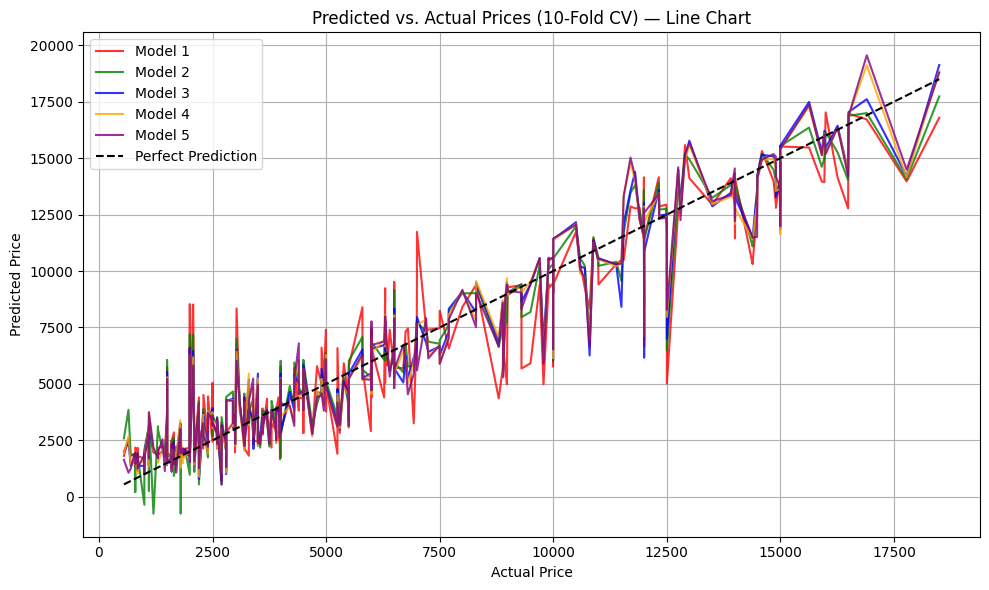

In [92]:
results = []
kf1 = KFold(n_splits=k_fold, shuffle=True, random_state=42)

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((np.array(actuals), np.array(preds)))

# Sort by actual price to align line charts
sorted_indices = np.argsort(results[0][0])  # use actuals from model 1 for consistent sorting
sorted_actual = results[0][0][sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, (actual, pred) in enumerate(results):
    sorted_pred = pred[sorted_indices]
    plt.plot(sorted_actual, sorted_pred, label=f'Model {i+1}', color=colors[i], alpha=0.8)

# Perfect prediction line
plt.plot(sorted_actual, sorted_actual, 'k--', label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (10-Fold CV) — Line Chart")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

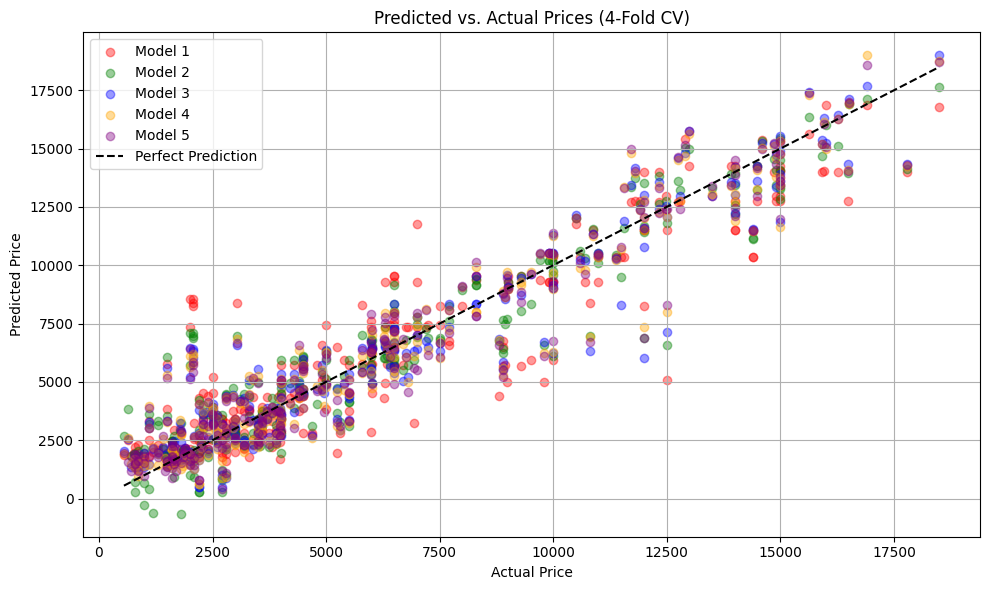

In [93]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
results = []

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((actuals, preds))

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, (actual, pred) in enumerate(results):
    plt.scatter(actual, pred, alpha=0.4, label=f'Model {i+1}', color=colors[i])

plt.plot(
    [data['price'].min(), data['price'].max()],
    [data['price'].min(), data['price'].max()],
    'k--', label='Perfect Prediction'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (4-Fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prediction

In [94]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [95]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [96]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [97]:
pd.concat([new, new], ignore_index=True)

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
1,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [98]:
reg1 = regs[0]
reg3 = regs[2]

In [99]:
reg1.resid.describe()


count    2.810000e+02
mean     1.076117e-10
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [100]:
(reg3.fittedvalues - data.price).describe()


count    2.810000e+02
mean     5.626568e-11
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.

In [101]:
help(point_predict_with_conf_int)

NameError: name 'point_predict_with_conf_int' is not defined

In [ ]:
p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.8, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80.append(p95.loc["Prediction Interval (95%)"])